In [1]:
%matplotlib inline
import openpathsampling.analysis.transition_state_ensemble as tse
import openpathsampling as paths

# Simple Transition State Ensemble Example
## Set up the simple_tps example from openpathsampling

### Prepare the MD engine

In [2]:
import openpathsampling.engines.toy as toys
import numpy as np

pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))
topology = toys.Topology(n_spatial=2, masses=[1.0], pes=pes)
engine = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 5000,
                              'n_steps_per_frame': 5}, topology)
template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

### Define the Collective Variable and States

In [3]:
def xval(snapshot):
    return snapshot.xyz[0][0]

cv = paths.FunctionCV("xval", xval)

In [4]:
stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.5).named("A")
stateB = paths.CVDefinedVolume(cv, 0.5, float("inf")).named("B")

### Set up the Network, Scheme and Initial Conditions

In [5]:
network = paths.TPSNetwork(stateA, stateB)

In [6]:
scheme = paths.OneWayShootingMoveScheme(network, engine=engine)

In [7]:
trajectory = paths.Trajectory([
    toys.Snapshot(coordinates=np.array([[-.55+k*0.1, 0.0]]),
                  velocities=np.array([[0.1, 0.0]]),
                  engine=engine)
    for k in range(12)
])

In [8]:
initial_conditions = scheme.initial_conditions_from_trajectories(trajectory)

No missing ensembles.
No extra ensembles.


### Set up the storage and run the TPS simulation

In [9]:
storage = paths.Storage("simple.nc", "w", template=template)
simulation = paths.PathSampling(storage, scheme, initial_conditions)

In [10]:
simulation.run(100)

Working on Monte Carlo cycle number 100
Running for 9 seconds - 10.85 steps per second
Expected time to finish: 0 seconds
DONE! Completed 100 Monte Carlo cycles.


### Get the decorrelated trajectories from the tps run

In [11]:
import openpathsampling.visualize as ops_vis
tree = ops_vis.PathTree(
    storage.steps[:],
    ops_vis.ReplicaEvolution(
        replica=0
    )
)
decorrelated_trajs = [sample.trajectory for sample in tree.generator.decorrelated]

## Set up the Transition State Ensemble
### Set up the randomizer, storage and logfile

In [12]:
beta = 10
randomizer = paths.RandomVelocities(beta=beta, engine=engine)
tse_storage = paths.Storage("toy_tse.nc", "w")
output = open("tse_output.log", "w")

### Set up the Transition State Ensemble object and redirect the output

In [13]:
tsensamble = tse.TransitionStateEnsemble(trajectories=decorrelated_trajs, 
                                         stateA=stateA,                 
                                         stateB=stateB,                 
                                         engine=engine,
                                         storage = tse_storage,          
                                         randomizer=randomizer, 
                                         n_per_snapshot=10,              
                                         pB_min=0.30,                    
                                         pB_max=0.70)                 
tsensamble.output_stream = output #Setting output_stream to a file

### Run the Transition State Ensemble Calculation and close the output

In [14]:
results = tsensamble.run()
output.close()

## Visualisation

Because the results of the transition state ensemble is in the shape of ```{snapshot: committor_value}```, where the snapshot is in the transition state ensemble. You can visualise the data from these snapshots by looping over ```results```. The ```.xyz[0][.]``` is because snapshots are a trajectory of length 1.

### Plot on top off the 2D potential energy surface

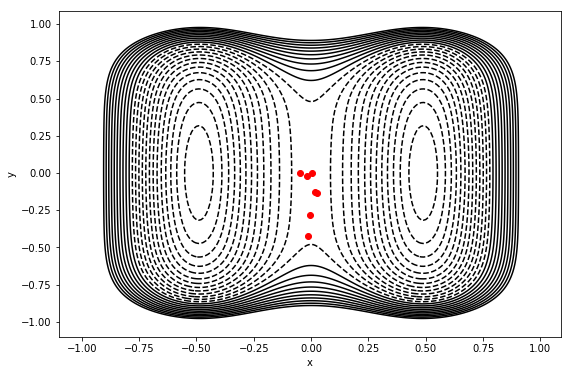

In [15]:
%run ../resources/toy_plot_helpers.py
import matplotlib.pyplot as plt

#Plot the background
plot = ToyPlot()
plot.contour_range = np.arange(-0.7, 0.5, 0.05)
plot.add_pes(pes)
fig = plot.plot()
plt.xlabel('x')
plt.ylabel('y')

# Plot the trajectories
for traj in decorrelated_trajs:
    x_traj = [s.xyz[0][0] for s in traj]
    y_traj = [s.xyz[0][1] for s in traj]
    #plt.plot(x_traj, y_traj, 'blue')

    # Plot the x and y value if the snapshot is in
    # the transition state ensemble
    x_tse = [s.xyz[0][0] for s in traj if s in results]
    y_tse = [s.xyz[0][1] for s in traj if s in results]
    plt.plot(x_tse, y_tse, 'ro')

### Plot as function of the collective variable

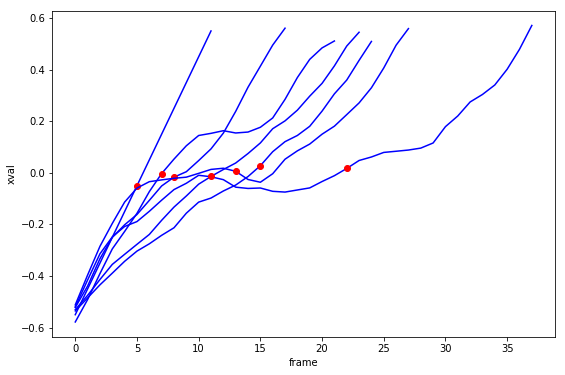

In [16]:
for traj in decorrelated_trajs:
    cv_traj = []
    cv_tse = 0
    frame_tse = 0
    for frame, snap in enumerate(traj):
        cv_traj.append(xval(snap))
        if snap in results:
            cv_tse = xval(snap)
            frame_tse = frame
    
    #Plot the cv value of the trajectory
    plt.plot(cv_traj, 'blue')
    
    #Plot the frame that is in te ensemble
    plt.plot(frame_tse, cv_tse, 'ro')

#Label the axis
plt.xlabel('frame')
plt.ylabel('xval')

## Get the full data
If you want all the mc steps for shooting point analysis from the TSE simulation (i.e. for maximum likelihood optimization)

In [17]:
all_steps = tsensamble.all_steps
spa = paths.ShootingPointAnalysis(steps=all_steps, states=[stateA,stateB])
